# Best SegFormer Model Inferencing

In [1]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import os
from PIL import Image 
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

c:\aryan\Cracks\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Importing the best model

In [4]:
import torch

from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

model_saved = torch.load("C:/aryan/Cracks/segformer_checkpoints/b5_model_epoch_6.pt")
# checkpoint.items()[0]

model_saved.eval()


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

## Getting the Ground Truth 

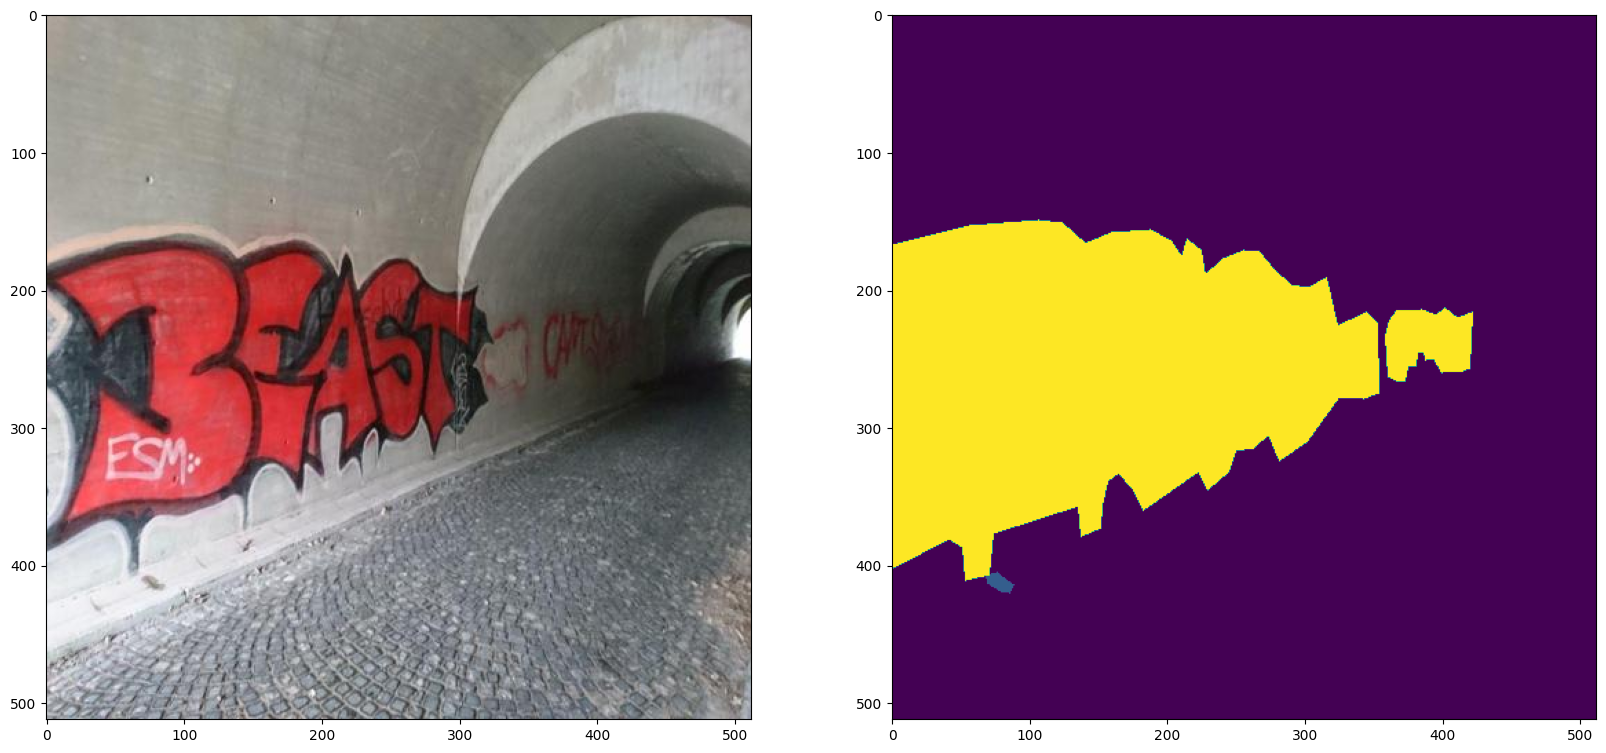

In [3]:
image = Image.open(r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\images\validation\dacl10k_v2_validation_0001.jpg')
mask = Image.open(r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\annotations\validation\dacl10k_v2_validation_0001.png').convert('L')

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
axs[1].imshow(mask)
plt.show()

## Predicting the Segmentation Maps

In [6]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, SegformerImageProcessor

# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerImageProcessor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [7]:
model_saved.eval()
outputs = model_saved(pixel_values=pixel_values)# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 20, 128, 128])


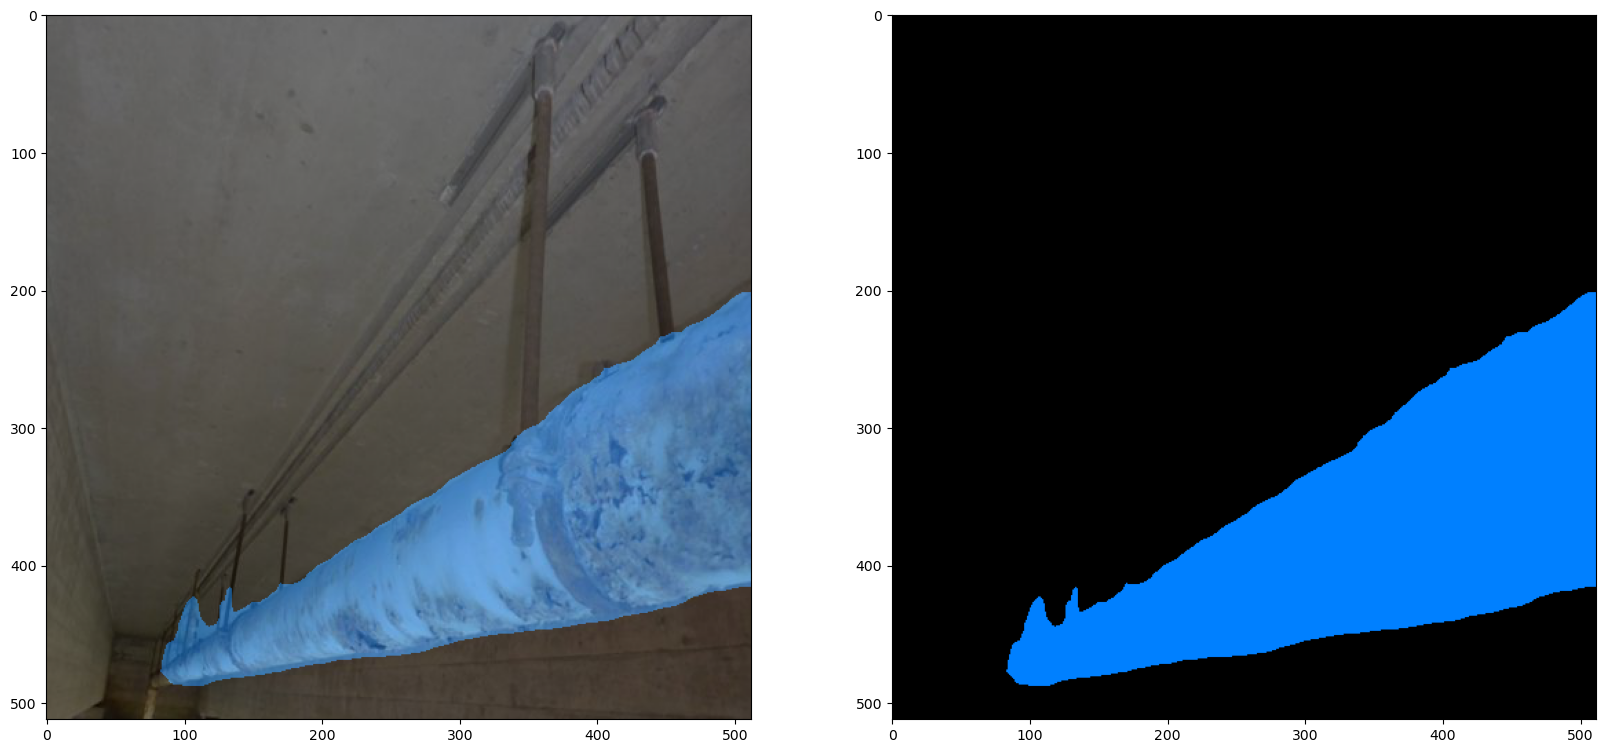

In [8]:
palette = [
    (0, 0, 0),       # Class 0: Red
    (0, 255, 0),     # Class 1: Green
    (0, 0, 255),     # Class 2: Blue
    (255, 255, 0),   # Class 3: Yellow
    (255, 0, 255),   # Class 4: Magenta
    (0, 255, 255),   # Class 5: Cyan
    (128, 0, 0),     # Class 6: Maroon
    (0, 128, 0),     # Class 7: Dark Green
    (0, 0, 128),     # Class 8: Navy
    (128, 128, 0),   # Class 9: Olive
    (128, 0, 128),   # Class 10: Purple
    (0, 128, 128),   # Class 11: Teal
    (192, 192, 192), # Class 12: Silver
    (128, 128, 128), # Class 13: Gray
    (255, 165, 0),   # Class 14: Orange
    (128, 0, 64),    # Class 15: Burgundy
    (255, 128, 0),   # Class 16: Dark Orange
    (0, 128, 64),    # Class 17: Forest Green
    (128, 64, 0),    # Class 18: Saddle Brown
    (255, 192, 203), # Class 19: Pink
    (0, 255, 127)    # Class 20: Lime green
]

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3

# Assign colors based on class index
for index, color in enumerate(palette):
    color_seg[seg == index, :] = color

# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(img)
axs[1].imshow(color_seg)

plt.show()

unique values seg:  [ 0 16]
unique values:  [  0 128 255]


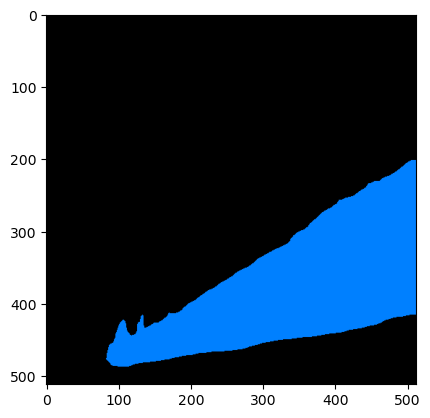

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assuming 'logits' is a tensor containing predictions from your model

# First, rescale logits to the original image size
upsampled_logits = torch.nn.functional.interpolate(logits,
                                                  size=image.size[::-1],  # (height, width)
                                                  mode='bilinear',
                                                  align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
print("unique values seg: ", np.unique(seg))
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)

# Assign colors based on the palette
for label, color in enumerate(palette):
    # print(label,color)
    color_seg[seg == label, :] = color
    # print("unique values color_seg: ", np.unique(color_seg))

# Convert to BGR
color_seg = color_seg[..., ::-1]
print("unique values: ", np.unique(color_seg))
# Save the segmentation mask using PIL
image_to_save = Image.fromarray(color_seg)
image_to_save.save("C:/aryan/Cracks/Segformer_checks/segmentation_mask.png")

plt.imshow(color_seg)
plt.show()

## Geting each class predictions

IndexError: index 5 is out of bounds for axis 0 with size 5

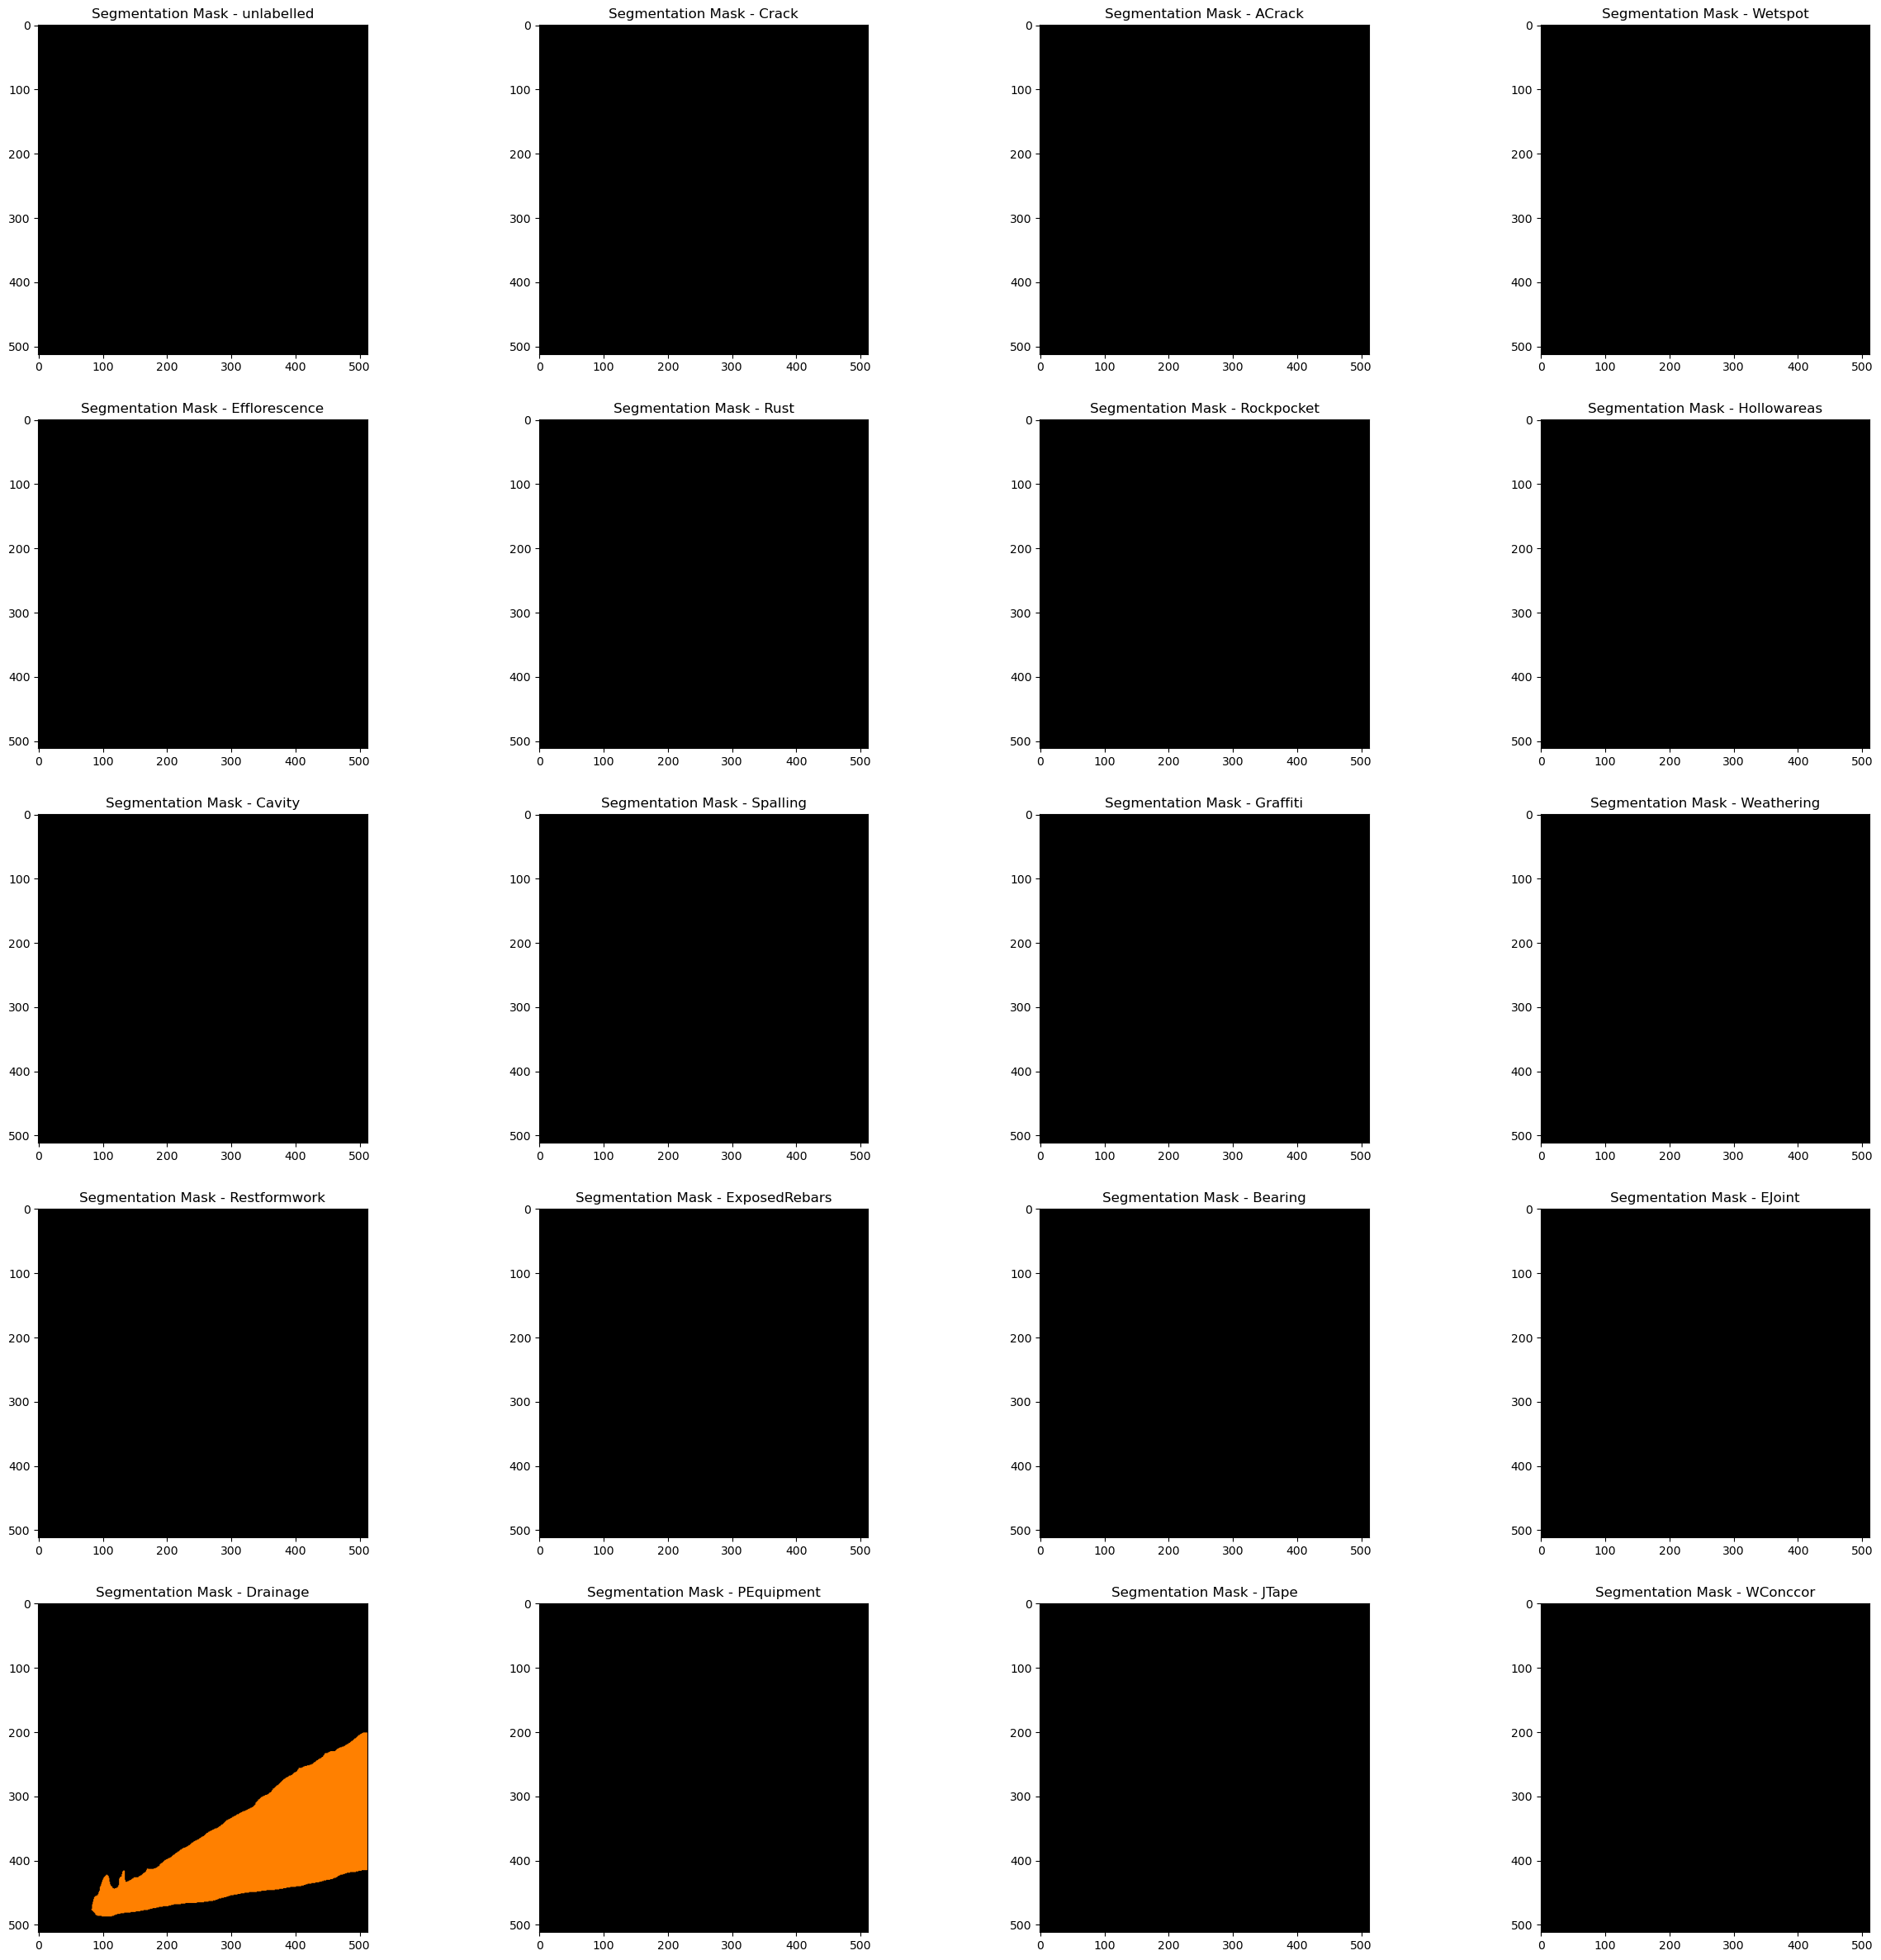

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'logits' is a tensor containing predictions from your model
# 'image' is the input image

class_mapping = {
    0: 'unlabelled',
    1: 'Crack',
    2: 'ACrack',
    3: 'Wetspot',
    4: 'Efflorescence',
    5: 'Rust',
    6: 'Rockpocket',
    7: 'Hollowareas',
    8: 'Cavity',
    9: 'Spalling',
    10: 'Graffiti',
    11: 'Weathering',
    12: 'Restformwork',
    13: 'ExposedRebars',
    14: 'Bearing',
    15: 'EJoint',
    16: 'Drainage',
    17: 'PEquipment',
    18: 'JTape',
    19: 'WConccor'
}

# First, rescale logits to original image size
upsampled_logits = torch.nn.functional.interpolate(logits,
                                                  size=image.size[::-1],  # (height, width)
                                                  mode='bilinear',
                                                  align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]

# Create a subplot for each class
num_classes = len(palette)
# Adjust the figure size to accommodate 20 classes
fig, axs = plt.subplots(5, 4, figsize=(30, 30))  # 5 rows, 4 columns

# Display the original image
axs[0, 0].imshow(np.array(image))
axs[0, 0].set_title('Original Image')

# Display segmentation masks for each class
for i, color in enumerate(palette):
    row = int(i // 4)  # To distribute classes across 5 rows
    col = i % 4  # To fit 4 classes per row

    class_mask = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    class_mask[seg == i, :] = color
    axs[row, col].imshow(class_mask)
    axs[row, col].set_title(f'Segmentation Mask - {class_mapping[i]}')

plt.tight_layout()  # Adjust layout for better visualization
plt.show()


## Saving Predictions

In [17]:
import os
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Assuming feature_extractor_inference and model_saved are defined somewhere in your code
# feature_extractor_inference(image, return_tensors="pt") should return pixel_values

def perform_segmentation(image_path):
    # Load the image
    image = Image.open(image_path).convert('RGB')
    pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
    outputs = model_saved(pixel_values=pixel_values)
    logits = outputs.logits.cpu()

    # Rescale logits to the original image size
    upsampled_logits = F.interpolate(logits,
                                     size=image.size[::-1],  # (height, width)
                                     mode='bilinear',
                                     align_corners=False)

    # Apply argmax on the class dimension
    seg = upsampled_logits.argmax(dim=1)[0]

    return seg

In [18]:

# Set the path to your images folder
input_folder = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/data/data_megazord/images/validation/'

# Set the path to save the output plots
output_folder = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/data/data_megazord/predictions_b5_best/'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Iterate through all images in the input folder
for filename in os.listdir(input_folder):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Get the full path of the image
        image_path = os.path.join(input_folder, filename)

        # Perform segmentation on the image
        seg_map = perform_segmentation(image_path)
        # print(color_seg)

        output_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.png")


        # # Save the segmentation mask using PIL
        image_to_save = Image.fromarray(seg_map.numpy().astype(np.uint8))
        image_to_save.save(output_path)

        # Save the segmentation 
print("Segmentation plots saved to:", output_folder)


Segmentation plots saved to: C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/data/data_megazord/predictions_b5_best/


## Calcultaing mIOU

### mIOU for a Single Image (Testing)

In [11]:
from PIL import Image
import numpy as np

def read_mask_multiclass(image_path):
    mask_image = Image.open(image_path)
    
    # Convert to grayscale
    mask_image = mask_image.convert("L")
    
    mask_array = np.array(mask_image)
    return mask_array

def calculate_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask)
    union = np.logical_or(gt_mask, pred_mask)

    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0.0
    print("iou: ", iou)
    return iou

def calculate_miou(gt_masks, pred_masks):
    unique_classes = np.unique(gt_masks)
    
    # Exclude class zero
    unique_classes = unique_classes[unique_classes != 0]
    
    class_ious = []

    for class_id in unique_classes:
        gt_class_mask = gt_masks == class_id
        pred_class_mask = pred_masks == class_id

        iou = calculate_iou(gt_class_mask, pred_class_mask)
        class_ious.append(iou)

    miou = np.mean(class_ious) if len(class_ious) > 0 else 0.0
    return miou

def calculate_specific_class_miou(gt_masks, pred_masks):
    unique_classes = np.unique(gt_masks)
    
    # Exclude class zero
    unique_classes = unique_classes[unique_classes != 0]
    
    class_ious = {}

    for class_id in unique_classes:
        gt_class_mask = gt_masks == class_id
        pred_class_mask = pred_masks == class_id

        iou = calculate_iou(gt_class_mask, pred_class_mask)
        class_ious[class_id] = iou

    return class_ious

# Example usage:
# Replace 'path/to/gt_mask.png' and 'path/to/pred_mask.png' with the actual paths to your ground truth and predicted mask images
gt_mask_path = r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\annotations\validation\dacl10k_v2_validation_0882.png'
pred_mask_path = r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\predictions_b5_best\dacl10k_v2_validation_0882.png'

gt_mask = read_mask_multiclass(gt_mask_path)
print("Unique values in the gt_mask:", np.unique(gt_mask))
print("gt_mask shape:", gt_mask.shape)

pred_mask = read_mask_multiclass(pred_mask_path)
print("Unique values in the pred_mask:", np.unique(pred_mask))
print("pred_mask shape:", pred_mask.shape)

class_ious = calculate_specific_class_miou(gt_mask, pred_mask)
print("Class-wise IoU:", class_ious)

miou = calculate_miou(gt_mask, pred_mask)
print(f"Mean IoU (excluding class zero): {miou}")

Unique values in the gt_mask: [ 0  5 11 16]
gt_mask shape: (512, 512)
Unique values in the pred_mask: [ 0 16]
pred_mask shape: (512, 512)
iou:  0.0
iou:  0.0
iou:  0.9251293630633174
Class-wise IoU: {5: 0.0, 11: 0.0, 16: 0.9251293630633174}
iou:  0.0
iou:  0.0
iou:  0.9251293630633174
Mean IoU (excluding class zero): 0.3083764543544391


### mIOU for all Predictions

In [20]:
import os

# Path to the predicted and validation folders
predicted_folder = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/data/data_megazord/predictions_b5_best'
# predicted_folder = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/data/data_megazord/readjusted_prediction'

validation_folder = 'C:/aryan/Cracks/data/dacl10k_v2_devphase/resized/data/data_megazord/annotations/validation'

# Get a list of all files in the predicted folder
predicted_files = os.listdir(predicted_folder)

# Initialize a list to store mean IoU values for each image pair
mean_ious = []

# Loop through each predicted file
for predicted_file in predicted_files:

    if "horizontal" in predicted_file.lower() or "vertical" in predicted_file.lower():
        # print(f"Ignoring file: {predicted_file}")
        continue

    # Construct the paths for the current pair of images
    gt_mask_path = os.path.join(validation_folder, predicted_file)
    pred_mask_path = os.path.join(predicted_folder, predicted_file)

    # Check if the corresponding ground truth mask exists
    if os.path.exists(gt_mask_path):
        # Read masks
        gt_mask = read_mask_multiclass(gt_mask_path)
        pred_mask = read_mask_multiclass(pred_mask_path)

        # Calculate mean IoU
        miou = calculate_miou(gt_mask, pred_mask)
        print(f"Mean IoU for {predicted_file}: {miou}")
        mean_ious.append(miou)

# Calculate the overall mean IoU across all images
overall_mean_iou = np.mean(mean_ious)
print(f"Overall Mean IoU: {overall_mean_iou}")


iou:  0.22707675190240606
Mean IoU for dacl10k_v2_validation_0000.png: 0.22707675190240606
iou:  0.0
iou:  0.9131442635148671
Mean IoU for dacl10k_v2_validation_0001.png: 0.45657213175743355
iou:  0.7269032560318576
iou:  0.0
Mean IoU for dacl10k_v2_validation_0002.png: 0.3634516280159288
iou:  0.7997041685342896
iou:  0.0
iou:  0.00990557840468053
Mean IoU for dacl10k_v2_validation_0003.png: 0.2698699156463234
iou:  0.8486021750270455
iou:  0.7408703590992087
Mean IoU for dacl10k_v2_validation_0004.png: 0.794736267063127
iou:  0.26801595508937803
Mean IoU for dacl10k_v2_validation_0005.png: 0.26801595508937803
iou:  0.0
iou:  0.0
iou:  0.0
Mean IoU for dacl10k_v2_validation_0006.png: 0.0
iou:  0.8787870110532043
Mean IoU for dacl10k_v2_validation_0007.png: 0.8787870110532043
iou:  0.12096300645918967
iou:  0.0
Mean IoU for dacl10k_v2_validation_0008.png: 0.060481503229594835
iou:  0.0
iou:  0.0
iou:  0.0
Mean IoU for dacl10k_v2_validation_0009.png: 0.0
iou:  0.6904473085670962
Mean Io

### mIOU for classes

In [21]:
import os

def calculate_class_miou_for_folder(gt_folder, pred_folder):
    # Get a list of all image files in the folder
    gt_files = os.listdir(gt_folder)
    pred_files = os.listdir(pred_folder)

    # Initialize a dictionary to accumulate class-wise IoU values
    class_ious_accumulated = {}

    # Iterate over each image file
    for gt_file in gt_files:
        
        # Construct the paths for the current image
        gt_path = os.path.join(gt_folder, gt_file)
        pred_file = gt_file  # Assuming the predicted masks have the same filenames
        pred_path = os.path.join(pred_folder, pred_file)

        # Read the masks
        gt_mask = read_mask_multiclass(gt_path)
        pred_mask = read_mask_multiclass(pred_path)

        # Calculate class-wise IoU for the current image
        class_ious = calculate_specific_class_miou(gt_mask, pred_mask)
        print(class_ious)

        # Accumulate the IoU values for each class
        for class_id, iou in class_ious.items():
            if class_id not in class_ious_accumulated:
                class_ious_accumulated[class_id] = []
            class_ious_accumulated[class_id].append(iou)

    # Calculate the mean IoU for each class
    class_means = {}
    for class_id, iou_values in class_ious_accumulated.items():
        mean_iou = np.mean(iou_values)
        class_means[class_id] = mean_iou

    return class_means

# Example usage:
# Replace 'path/to/gt_folder' and 'path/to/pred_folder' with the actual paths to your ground truth and predicted mask folders
gt_folder_path = r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\annotations\validation'
pred_folder_path = r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\predictions_b5_best'

class_means = calculate_class_miou_for_folder(gt_folder_path, pred_folder_path)

# Print or use the mean IoU values for each class
for class_id, mean_iou in class_means.items():
    print(f"Class {class_id}: Mean IoU = {mean_iou}")


iou:  0.22707675190240606
{10: 0.22707675190240606}
iou:  0.0
iou:  0.9131442635148671
{3: 0.0, 10: 0.9131442635148671}
iou:  0.7269032560318576
iou:  0.0
{10: 0.7269032560318576, 11: 0.0}
iou:  0.7997041685342896
iou:  0.0
iou:  0.00990557840468053
{7: 0.7997041685342896, 9: 0.0, 10: 0.00990557840468053}
iou:  0.8486021750270455
iou:  0.7408703590992087
{10: 0.8486021750270455, 17: 0.7408703590992087}
iou:  0.26801595508937803
{10: 0.26801595508937803}
iou:  0.0
iou:  0.0
iou:  0.0
{9: 0.0, 11: 0.0, 16: 0.0}
iou:  0.8787870110532043
{10: 0.8787870110532043}
iou:  0.12096300645918967
iou:  0.0
{9: 0.12096300645918967, 10: 0.0}
iou:  0.0
iou:  0.0
iou:  0.0
{5: 0.0, 9: 0.0, 14: 0.0}
iou:  0.6904473085670962
{12: 0.6904473085670962}
iou:  0.055632823365785816
iou:  0.27952790072029854
iou:  0.0
{1: 0.055632823365785816, 12: 0.27952790072029854, 15: 0.0}
iou:  0.03788325471698113
iou:  0.0
{4: 0.03788325471698113, 9: 0.0}
iou:  0.0002795638803466592
iou:  0.11277424380111645
iou:  0.0
{9:

In [19]:
import os

def calculate_class_miou_for_folder(gt_folder, pred_folder):
    # Get a list of all image files in the prediction folder
    pred_files = os.listdir(pred_folder)

    # Initialize a dictionary to accumulate class-wise IoU values
    class_ious_accumulated = {}

    # Iterate over each prediction file
    for pred_file in pred_files:
        if "horizontal" in pred_file.lower() or "vertical" in pred_file.lower():
        # print(f"Ignoring file: {predicted_file}")
            continue

        # Construct the paths for the current prediction image
        pred_path = os.path.join(pred_folder, pred_file)

        # Extract the base filename without extension
        base_filename = os.path.splitext(pred_file)[0]

        # Construct the path for the corresponding ground truth image
        gt_file = f"{base_filename}.png"  # Assuming the ground truth images have the same filenames with .png extension
        gt_path = os.path.join(gt_folder, gt_file)

        # Check if the ground truth file exists for the current prediction file
        if os.path.exists(gt_path):
            # Read the masks
            gt_mask = read_mask_multiclass(gt_path)
            pred_mask = read_mask_multiclass(pred_path)

            # Calculate class-wise IoU for the current image
            class_ious = calculate_specific_class_miou(gt_mask, pred_mask)

            # Accumulate the IoU values for each class
            for class_id, iou in class_ious.items():
                if class_id not in class_ious_accumulated:
                    class_ious_accumulated[class_id] = []
                class_ious_accumulated[class_id].append(iou)
        else:
            print(f"Warning: Ground truth file not found for prediction file '{pred_file}'. Skipping.")

    # Calculate the mean IoU for each class
    class_means = {}
    for class_id, iou_values in class_ious_accumulated.items():
        mean_iou = np.mean(iou_values)
        class_means[class_id] = mean_iou

    return class_means

# Example usage:
# Replace 'path/to/gt_folder' and 'path/to/pred_folder' with the actual paths to your ground truth and predicted mask folders
gt_folder_path = r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\annotations\validation'
pred_folder_path = r'C:\aryan\Cracks\data\dacl10k_v2_devphase\resized\data\data_megazord\predictions'

class_means = calculate_class_miou_for_folder(gt_folder_path, pred_folder_path)

# Print or use the mean IoU values for each class
for class_id, mean_iou in class_means.items():
    print(f"Class {class_id}: Mean IoU = {mean_iou}")


iou:  0.20509269124227572
iou:  0.0
iou:  0.7569416623008414
iou:  0.7585897213048265
iou:  0.0
iou:  0.6831842380528624
iou:  0.0
iou:  0.0
iou:  0.740709832605174
iou:  0.7035210328870947
iou:  0.19434447300771207
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.8890589569160998
iou:  0.20052671181339352
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.7147234678624813
iou:  0.0
iou:  0.16351913899888312
iou:  0.0
iou:  0.047016048144433296
iou:  0.0
iou:  0.054635761589403975
iou:  0.08693524425412916
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.13847654133708961
iou:  0.1956166175989532
iou:  0.17236798405845233
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.3045076417101954
iou:  0.0
iou:  0.618314243124049
iou:  0.0
iou:  0.0
iou:  0.39418688445832334
iou:  0.0
iou:  0.0038876889848812094
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.637983598124783
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.0
iou:  0.8560751770